In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from ProjectPaths import ProjectPaths

ProjectPaths.instance()

In [40]:
mask_images = np.load(ProjectPaths.instance().file_in_image_dir("ds_image_masks.npy")) 
mask_images = (mask_images / 255).astype(np.uint8)

In [26]:
images = np.load(ProjectPaths.instance().file_in_image_dir("ds_images.npy"))

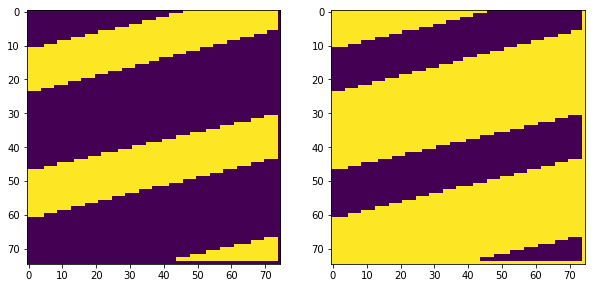

In [41]:
%matplotlib inline

def inverse_mask(mask):
    return ((mask == 0)).astype(np.uint8)

_, ax = plt.subplots(1,2, figsize = (10,10))

mask = mask_images[0]
inv_mask = inverse_mask(mask)

ax[0].imshow(mask)
ax[1].imshow(inv_mask)

In [42]:
mask.dtype, inv_mask.dtype, mask.max(), inv_mask.max()

(dtype('uint8'), dtype('uint8'), 1, 1)

In [29]:
inverse_masks = [inverse_mask(mask) for mask in mask_images]

In [43]:
def normalized_hist(hist_image, channel, mask=None):
    hist = cv.calcHist([hist_image], [channel], mask, [256], [0, 255])  
    number_of_pixels = hist_image.size if mask is None else mask[mask > 0].size
    return hist / number_of_pixels

def all_bands_hist(hist_image, mask=None):
    all_bands_hist = []
    for i in range(3):
        all_bands_hist.extend(normalized_hist(hist_image, i, mask))
    return np.array(all_bands_hist)

def plot_hist(hist_image, mask=None):
    normalized_counts = []
    for i, col in enumerate(["b", "g", "r"]):
        normalized_counts.append(normalized_hist(hist_image, i, mask))
        plt.plot(normalized_counts,color = col)
        plt.xlim([0,255])
    return np.array(normalized_counts)

In [31]:
def image_with_mask(image, mask):    
    mask = np.stack([mask for i in range(image.shape[2])], axis = 2)
    return mask * image

In [32]:
image_with_mask(images[0], mask_images[0]).shape

(75, 75, 3)

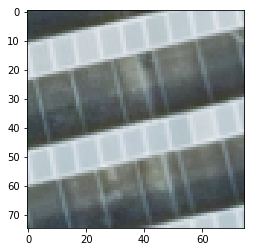

In [44]:
plt.imshow(images[0][:,:,::-1])

In [45]:
positive_images = np.array([image_with_mask(hist_image, mask) for hist_image, mask in zip(images, mask_images)])
negative_images = np.array([image_with_mask(hist_image, mask) for hist_image, mask in zip(images, inverse_masks)])

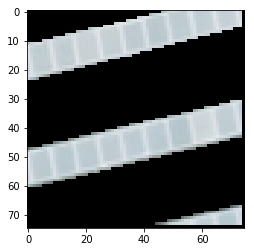

In [46]:
plt.imshow(positive_images[0][:,:,::-1])

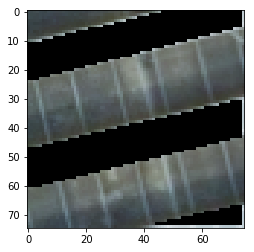

In [36]:
plt.imshow(negative_images[0][:,:,::-1])

In [17]:
positives = np.array([all_bands_hist(hist_image, mask) for hist_image, mask in zip(images, mask_images)]).reshape(120, 768)
negatives = np.array([all_bands_hist(hist_image, mask) for hist_image, mask in zip(images, inverse_masks)]).reshape(120, 768)

In [18]:
positives.shape, negatives.shape

((120, 768), (120, 768))

In [19]:
positive_labels = np.ones(120)
negative_labels = np.zeros(120)

In [20]:
all_histograms = np.concatenate((positives, negatives))
all_labels = np.concatenate((positive_labels, negative_labels))
all_histograms.shape, all_labels.shape

((240, 768), (240,))

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_histograms, all_labels, test_size = 0.20)

In [22]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier()
clf.fit(X_train, y_train)

/home/tdjg/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def predict(clf, X_test, y_test):
    predictions = clf.predict(X_test)
    print(classification_report(y_test, predictions))
    print("accuracy={}".format(accuracy_score(y_test, predictions)))
    print(confusion_matrix(y_test, predictions))

In [24]:
predict(clf, X_test, y_test)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        23
         1.0       1.00      0.92      0.96        25

   micro avg       0.96      0.96      0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48

accuracy=0.9583333333333334
[[23  0]
 [ 2 23]]


In [25]:
clf.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00533217, 0.        ,
       0.        , 0.        , 0.01011377, 0.        , 0.     

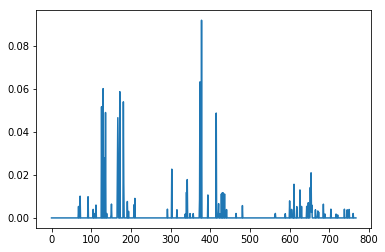

In [26]:
plt.plot(clf.feature_importances_)

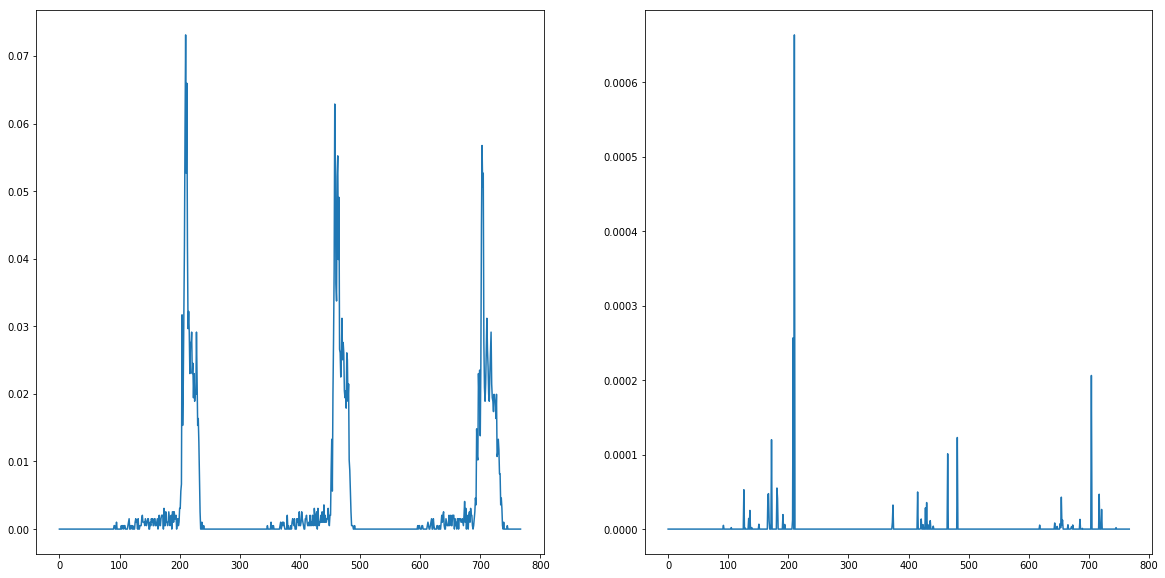

In [27]:
_, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(all_histograms[0])
ax[1].plot(all_histograms[0] * clf.feature_importances_)

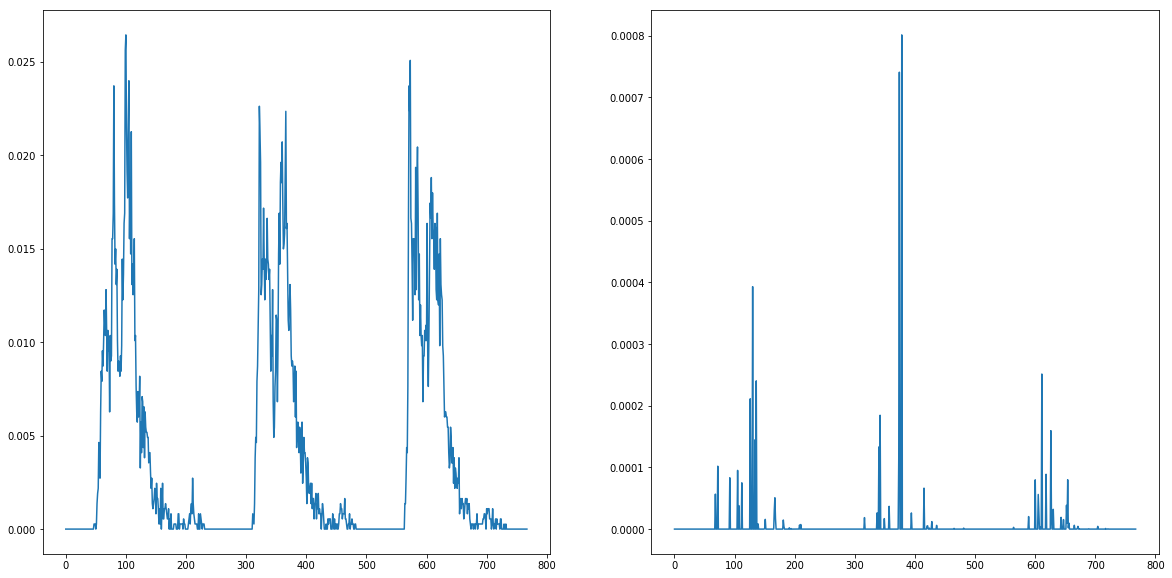

In [28]:
_, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(all_histograms[120])
ax[1].plot(all_histograms[120] * clf.feature_importances_)

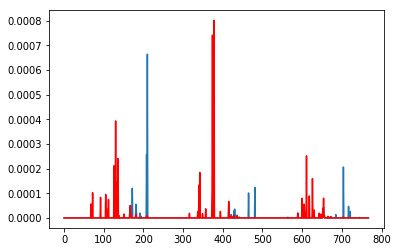

In [29]:
plt.plot(all_histograms[0] * clf.feature_importances_)
plt.plot(all_histograms[120] * clf.feature_importances_, color='r')

# Look at the combined histograms

Sum the separate normalized histogram vectors for each of the separate images to create a combined histogram for all the pictures. By comparing the histograms of the foreground (containing solar panels) with the histograms of the background (without solar panels) we can get an idea of which colors are more important in the foreground pictures, and which ones are more important in background pictures. If we furthermore use feature importances to weigh the histograms, we get an idea which features (=colors) are used to discriminate between classifier classes.

In [30]:
positives_summed_hist = positives.sum(axis=0)
negatives_summed_hist = negatives.sum(axis=0)

In [32]:
positives_summed_hist.min(), positives_summed_hist.max(), negatives_summed_hist.min(), negatives_summed_hist.max()

(0.0, 2.4751441, 0.0, 1.1511271)

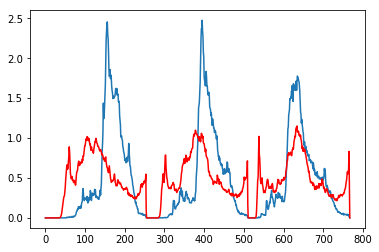

In [29]:
plt.plot(positives_summed_hist)
plt.plot(negatives_summed_hist, color='r')

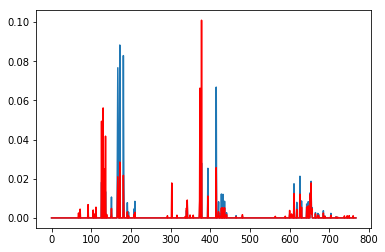

In [33]:
plt.plot(positives_summed_hist * clf.feature_importances_)
plt.plot(negatives_summed_hist * clf.feature_importances_, color='r')

(0, 0.08)

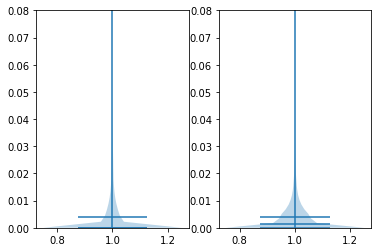

In [34]:
_, ax = plt.subplots(1,2)

ax[0].violinplot(positives.flatten(), showmedians=True, showmeans=True)
ax[0].set_ylim([0, 0.08])
ax[1].violinplot(negatives.flatten(), showmedians=True, showmeans=True)
ax[1].set_ylim([0, 0.08])

# Which features are important?

Explore which features are important to detect solar panels:
* color (normalized rgb images?)
* intensity (gray scale picture)
* texture (local binary patterns)

For each of these values create a normalized histogram of the values for the whole pictures and add them to a feature vector to be used in a classifier. By using a classifier with feature importances, like a RandomForestClassifier, we can get an idea of the relative importances of each feature type.

## RGB Normalized Pictures

To calculate the RGB normalized picture all pixels in each image channel are divided by the total intensity of the pixel. This results in:

\begin{equation}
r' = \frac{r}{r+g+b}
\end{equation}
\begin{equation}
b' = \frac{b}{r+g+b}
\end{equation}
\begin{equation}
g' = \frac{g}{r+g+b}
\end{equation}

Note that only two channels are necessary to reconstruct the picture, when having r' and b', g' is derived as follows:

\begin{equation}
g' = 1 - r' - g'
\end{equation}

In [35]:
def rgb_norm(image):
    sums = image.sum(axis=2).reshape(image.shape[0], image.shape[1], 1).repeat(axis=2, repeats=3)
    return image / sums

In [36]:
rgb_normalized_images = np.array([rgb_norm(image) * 255 for image in images]).astype(np.uint8)
rgb_normalized_images.shape, rgb_normalized_images.dtype

((120, 75, 75, 3), dtype('uint8'))

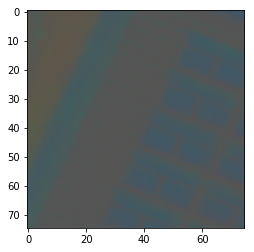

In [37]:
plt.imshow(rgb_normalized_images[3][:,:,::-1])

In [38]:
rgb_positives = np.array([all_bands_hist(hist_image, mask) for hist_image, mask in zip(rgb_normalized_images, mask_images)]).reshape(120, 768)
rgb_negatives = np.array([all_bands_hist(hist_image, mask) for hist_image, mask in zip(rgb_normalized_images, inverse_masks)]).reshape(120, 768)
rgb_positives.shape, rgb_negatives.shape

((120, 768), (120, 768))

In [39]:
# This is OpenCV so BGR color space
rgb_feature_names = ["{}_{}".format(color,i) for color in ["b", "g", "r"] for i in range(256)]
rgb_feature_names

['b_0',
 'b_1',
 'b_2',
 'b_3',
 'b_4',
 'b_5',
 'b_6',
 'b_7',
 'b_8',
 'b_9',
 'b_10',
 'b_11',
 'b_12',
 'b_13',
 'b_14',
 'b_15',
 'b_16',
 'b_17',
 'b_18',
 'b_19',
 'b_20',
 'b_21',
 'b_22',
 'b_23',
 'b_24',
 'b_25',
 'b_26',
 'b_27',
 'b_28',
 'b_29',
 'b_30',
 'b_31',
 'b_32',
 'b_33',
 'b_34',
 'b_35',
 'b_36',
 'b_37',
 'b_38',
 'b_39',
 'b_40',
 'b_41',
 'b_42',
 'b_43',
 'b_44',
 'b_45',
 'b_46',
 'b_47',
 'b_48',
 'b_49',
 'b_50',
 'b_51',
 'b_52',
 'b_53',
 'b_54',
 'b_55',
 'b_56',
 'b_57',
 'b_58',
 'b_59',
 'b_60',
 'b_61',
 'b_62',
 'b_63',
 'b_64',
 'b_65',
 'b_66',
 'b_67',
 'b_68',
 'b_69',
 'b_70',
 'b_71',
 'b_72',
 'b_73',
 'b_74',
 'b_75',
 'b_76',
 'b_77',
 'b_78',
 'b_79',
 'b_80',
 'b_81',
 'b_82',
 'b_83',
 'b_84',
 'b_85',
 'b_86',
 'b_87',
 'b_88',
 'b_89',
 'b_90',
 'b_91',
 'b_92',
 'b_93',
 'b_94',
 'b_95',
 'b_96',
 'b_97',
 'b_98',
 'b_99',
 'b_100',
 'b_101',
 'b_102',
 'b_103',
 'b_104',
 'b_105',
 'b_106',
 'b_107',
 'b_108',
 'b_109',
 'b_110',


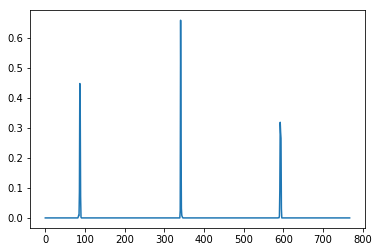

In [40]:
plt.plot(rgb_positives[0])

In [41]:
rgb_positives_summed_hist = rgb_positives.sum(axis=0)
rgb_negatives_summed_hist = rgb_negatives.sum(axis=0)

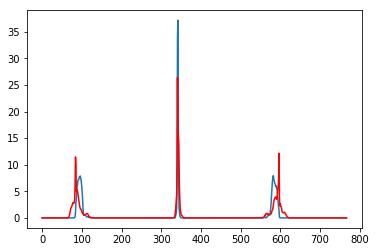

In [42]:
plt.plot(rgb_positives_summed_hist)
plt.plot(rgb_negatives_summed_hist, color="r")

## Intensity

Intensity is calculated by converting the picture to a gray-scale picture using OpenCV. By taking the histogram of this gray-scale picture we are able to extract the intensity as a feature vector.

In [43]:
gray_scale_images = np.array([cv.cvtColor(image, cv.COLOR_BGR2GRAY) for image in images])

In [44]:
gs_positive_images = np.array([hist_image * mask for hist_image, mask in zip(gray_scale_images, mask_images)])
gs_negative_images = np.array([hist_image * mask for hist_image, mask in zip(gray_scale_images, inverse_masks)])

In [45]:
gray_scale_positives = [cv.calcHist([hist_image], [0], mask, [256], [0, 255]) / mask.size for hist_image, mask in zip(gray_scale_images, mask_images)]
gray_scale_negatives = [cv.calcHist([hist_image], [0], mask, [256], [0, 255]) / mask.size for hist_image, mask in zip(gray_scale_images, inverse_masks)]
gray_scale_positives = np.array(gray_scale_positives).reshape(120, 256)
gray_scale_negatives = np.array(gray_scale_negatives).reshape(120, 256)
gray_scale_positives.shape, gray_scale_negatives.shape

((120, 256), (120, 256))

In [46]:
gray_scale_feature_names = ["gr_{}".format(i) for i in range(256)]

In [47]:
gray_scale_positives_summed_hist = gray_scale_positives.sum(axis=0)
gray_scale_negatives_summed_hist = gray_scale_negatives.sum(axis=0)

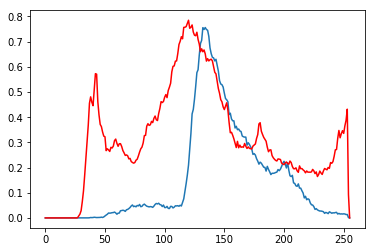

In [48]:
plt.plot(gray_scale_positives_summed_hist)
plt.plot(gray_scale_negatives_summed_hist, color="r")

## Texture differences

To get a feel for texture differences we will use the local binary patterns feature extractor, described here:

https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/

In short, this feature extractor looks at textures by comparing a middle pixel with its surrounding pixels and creating a binary mask out of it. If the middle pixel has an intensity greater than that of the surrounding pixel, the surrounding pixel position in the binary mask gets a value 0, otherwise 1. By creating a binary mask this way a value for the middle pixel is obtained. If we repeat this we get a mask image with the same size as the original image. By creating a histogram for this mask image, we can describe the texture information as a feature vector.

In [154]:
# Source: https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/
# import the necessary packages
from skimage import feature
from skimage.color import label2rgb
import numpy as np
 
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius      
       
    def calculate_lbp(self, image):
        return feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")

    def lbp_features(self, image, eps=1e-7):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        lbp = self.calculate_lbp(image)
        (hist, _) = np.histogram(lbp.ravel(),
            bins=np.arange(0, self.numPoints + 3),
            range=(0, self.numPoints + 2))

        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        return lbp, hist
    
    def describe(self, image, eps=1e-7):
        _, hist = self.lbp_features(image, eps)
        # return the histogram of Local Binary Patterns
        return hist
    
    def draw_into_image(self, image, labels):
        lbp_image = image.copy()
        lbp, _ = self.lbp_features(lbp_image)
        (hist, bin_edges) = np.histogram(lbp.ravel(), bins=np.arange(0, self.numPoints + 3), range=(0, self.numPoints + 2))
        mask = np.logical_or.reduce([lbp == bin_edges[each] for each in labels])
        lbp_image[mask] = 255
        return lbp_image
        

In [155]:
desc = LocalBinaryPatterns(24, 8)

texture_positives = np.array([desc.describe(gray_scale_image) for gray_scale_image in gs_positive_images])
texture_negatives = np.array([desc.describe(gray_scale_image) for gray_scale_image in gs_negative_images])
texture_positives.shape, texture_negatives.shape

((120, 26), (120, 26))

In [51]:
texture_feature_names = ["t_{}".format(i) for i in range(27)]

## Creating the classifier

By adding all the feature vectors derived above together we can create a feature vector describing color, intensity and texture. If we train a classifier to distinguish between a foreground (solar panel) region and a background region, we can furthermore derive which features are taken into account; that is, if the classifier has a way to derive feature importances. For this purpose, therefore we use a RandomForest classifier which can give us feature importances. In this way, we can get a coarse idea what distinguishes a solar panel from its background.

First we need to create the feature vectors from the vectors above:

In [52]:
feature_vectors_positives = np.array([np.concatenate((color, intensity, texture)) for color, intensity, texture in zip(rgb_positives, gray_scale_positives, texture_positives)])
feature_vectors_negatives = np.array([np.concatenate((color, intensity, texture)) for color, intensity, texture in zip(rgb_negatives, gray_scale_negatives, texture_negatives)])
feature_vectors_positives.shape, feature_vectors_negatives.shape

((120, 1050), (120, 1050))

In [53]:
feature_names = rgb_feature_names + gray_scale_feature_names + texture_feature_names

In [54]:
feature_vectors = np.vstack((feature_vectors_positives, feature_vectors_negatives))
feature_vectors.shape

(240, 1050)

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_vectors, all_labels, test_size = 0.20)

In [56]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier()
clf.fit(X_train, y_train)

/home/tdjg/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
predict(clf, X_test, y_test)

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96        28
         1.0       0.95      0.95      0.95        20

   micro avg       0.96      0.96      0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48

accuracy=0.9583333333333334
[[27  1]
 [ 1 19]]


In [58]:
clf.feature_importances_

array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.00607047])

In [59]:
feature_importances = [(name, importance) for name, importance in zip(feature_names, clf.feature_importances_) if importance > 0]
feature_importances.sort(key = lambda x: x[1],reverse=True)         
feature_importances

[('b_96', 0.07160542309490416),
 ('gr_111', 0.06265235424922612),
 ('b_83', 0.057805896427329896),
 ('t_7', 0.05597740010112891),
 ('gr_107', 0.04715683891311131),
 ('b_80', 0.046930833442359876),
 ('t_10', 0.04589371980676329),
 ('r_70', 0.037271623717590005),
 ('gr_57', 0.0347395562106942),
 ('t_5', 0.03417753847503319),
 ('gr_242', 0.03328012376281853),
 ('gr_241', 0.03157038123208487),
 ('r_91', 0.029116745611590965),
 ('gr_248', 0.02813576261800893),
 ('t_22', 0.026885108170552407),
 ('g_87', 0.02387644661035413),
 ('gr_144', 0.02011754751650482),
 ('r_86', 0.017773386926505902),
 ('r_95', 0.01772441395082905),
 ('g_89', 0.016010736983381357),
 ('t_19', 0.01468263046849183),
 ('b_79', 0.014540459772248469),
 ('gr_143', 0.013938742481681157),
 ('g_86', 0.012376730367412044),
 ('gr_140', 0.011638073021868822),
 ('gr_37', 0.011407784814955028),
 ('gr_237', 0.009947705951981335),
 ('t_21', 0.00811431015621239),
 ('gr_125', 0.008057929949519132),
 ('gr_41', 0.007494387524135955),
 ('g_

In [60]:
len(feature_importances)

75

Thus 66 out of 1050 features are used by the RandomForest classifier. Plot the selected feature importances together with their label. This seems to suggest that most information is present in some texture and intensity elements, a blue value (95), and several red values (69, 84, 85). As the DS dataset is quite biased we need to see if this is also true for other datasets.

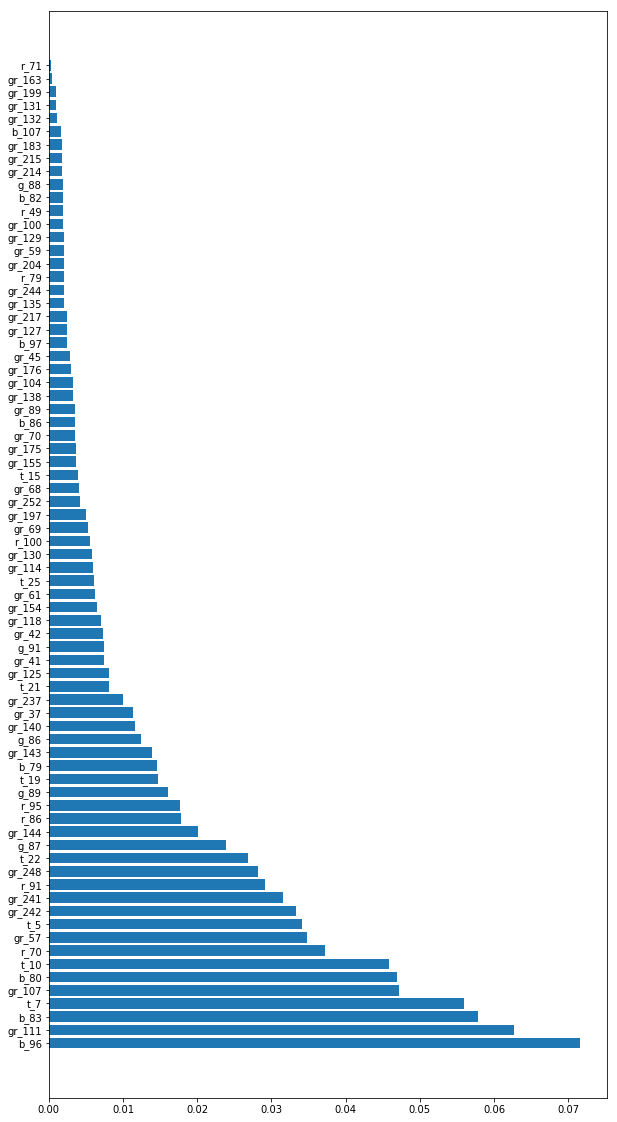

In [61]:
selected_feature_names = [x[0] for x in feature_importances]
selected_importances = [x[1] for x in feature_importances]

ind = np.arange(1, len(feature_importances) + 1)

plt.figure(figsize=(10,20))
h = plt.barh(ind, selected_importances, tick_label=selected_feature_names)

In [62]:
# Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

test = SelectKBest(score_func=chi2, k=30)
fit = test.fit(X_test, y_test)

selected_features_idx = fit.get_support()

selected_features = [name for name, selected in zip(feature_names, selected_features_idx) if selected]
selected_feature_scores = [score for score, selected in zip(fit.scores_, selected_features_idx) if selected]
name_and_scores = [(name, score) for name, score in zip(selected_features, selected_feature_scores)]
name_and_scores.sort(key = lambda x: x[1], reverse=True)
name_and_scores

[('t_24', 3.24006349621652),
 ('r_85', 2.0135320327795085),
 ('b_84', 1.8861383155644063),
 ('t_25', 1.8731636784266446),
 ('g_86', 1.5271692839065232),
 ('b_83', 1.250806432282666),
 ('r_69', 1.0160859889943485),
 ('b_85', 1.0067915856224747),
 ('r_70', 0.9842419458679785),
 ('b_96', 0.9579315003534963),
 ('r_86', 0.8190285295751389),
 ('r_68', 0.8080973863247709),
 ('b_97', 0.8060266245368308),
 ('b_95', 0.7628094321244465),
 ('g_82', 0.737165984981613),
 ('g_89', 0.7296529198699744),
 ('r_84', 0.7203505567193974),
 ('b_100', 0.713143512146164),
 ('b_94', 0.6683167546121496),
 ('r_71', 0.6664778522726854),
 ('b_82', 0.6516544219139163),
 ('b_101', 0.6226012118028259),
 ('r_67', 0.6078707398332572),
 ('r_66', 0.5846176353301514),
 ('b_99', 0.5734039651073999),
 ('b_102', 0.563364906917588),
 ('b_79', 0.5426514477553881),
 ('b_98', 0.5390378385545292),
 ('b_76', 0.4903578500462962),
 ('b_78', 0.4861966681411667)]

## PCA-based feature extraction

To extract independent color channels perform a PCA-transform on the image data. Create a histogram of the PCA-transformed channels to serve as features. The PCA is transformed on the normalized RGB data, so that we end up with independent color information without the intensity.

In [63]:
from sklearn.decomposition import PCA

def pca_transform(image, n_components=3):
    X = image.reshape(image.shape[0]*image.shape[1], image.shape[2])
    pca = PCA(n_components=n_components)
    pca.fit(X)
    return pca.transform(X).reshape(image.shape[0], image.shape[1], n_components)

In [64]:
pca_orig_images = np.array([pca_transform(image, 2) for image in images])
pca_orig_images.shape

(120, 75, 75, 2)

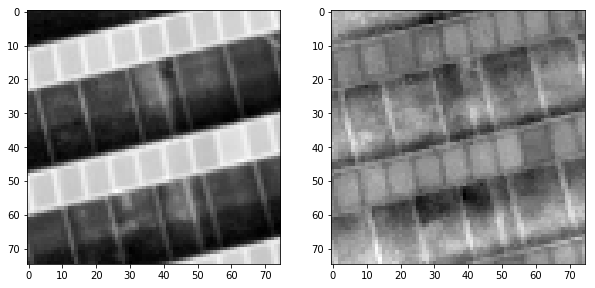

In [65]:
_, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(pca_orig_images[0][:,:,0], cmap="gray")
ax[1].imshow(pca_orig_images[0][:,:,1], cmap="gray")

In [66]:
pca_feature_names = ["pca_{}_{}".format(color,i) for color in ["c1", "c2"] for i in range(256)]

In [67]:
pca_image = images[0]

pca = PCA()

X = pca_image.reshape(pca_image.shape[0]*pca_image.shape[1], pca_image.shape[2])
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.components_)
print(pca.singular_values_)
print(pca.explained_variance_)

[9.97165853e-01 2.50324160e-03 3.30905055e-04]
[[ 0.60047329  0.57337797  0.55737736]
 [ 0.73617864 -0.12424807 -0.66528447]
 [ 0.3122064  -0.80981487  0.49671626]]
[7318.56244051  366.68527253  133.31953312]
[9.52371198e+03 2.39079106e+01 3.16040148e+00]


In [68]:
pca_orig_positive_images = np.array([image_with_mask(hist_image, mask) for hist_image, mask in zip(pca_orig_images, mask_images)])
pca_orig_negative_images = np.array([image_with_mask(hist_image, mask) for hist_image, mask in zip(pca_orig_images, inverse_masks)])

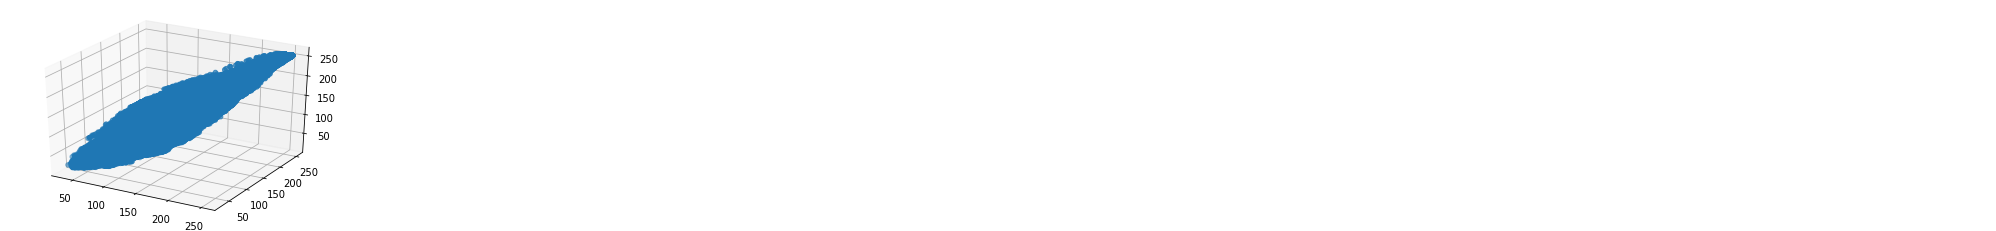

In [69]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(images.reshape(120 * 75 * 75, 3)[:, 0], images.reshape(120 * 75 * 75, 3)[:, 1],images.reshape(120 * 75 * 75, 3)[:, 2])

(-20000, 20000)

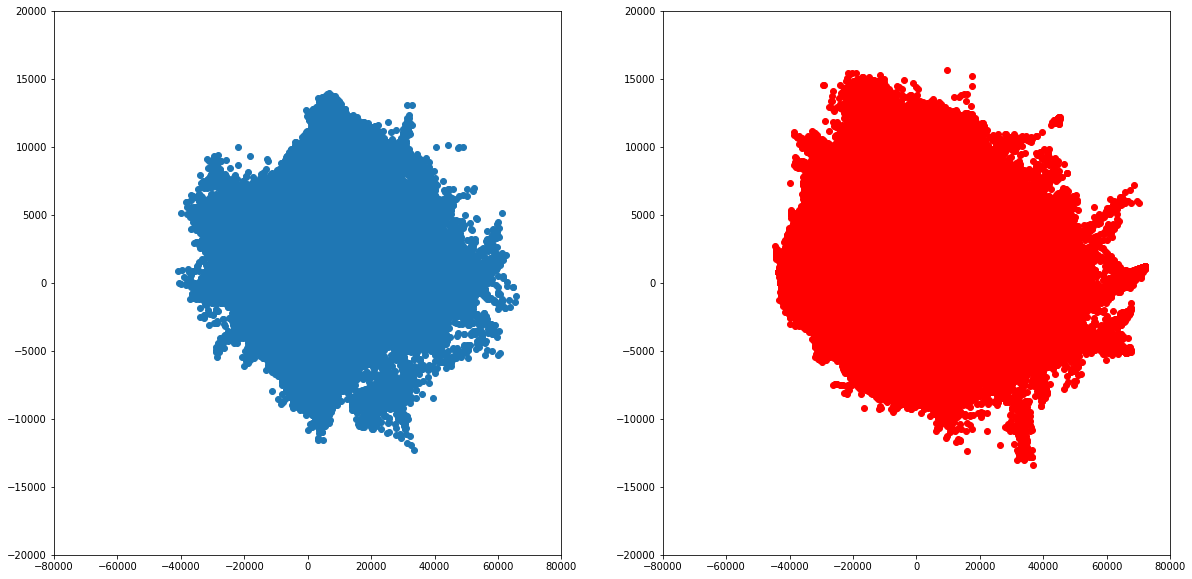

In [70]:
_, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].scatter(pca_orig_positive_images.reshape(120 * 75 * 75, 2)[:,0], pca_orig_positive_images.reshape(120 * 75 * 75,2)[:,1])
ax[1].scatter(pca_orig_negative_images.reshape(120 * 75 * 75, 2)[:,0], pca_orig_negative_images.reshape(120 * 75 * 75,2)[:,1], color='r')
ax[0].set_xlim(-80000,80000)
ax[1].set_xlim(-80000,80000)

ax[0].set_ylim(-20000,20000)
ax[1].set_ylim(-20000,20000)

In [71]:
pca_image = rgb_normalized_images[0]

pca = PCA()

X = pca_image.reshape(pca_image.shape[0]*pca_image.shape[1], pca_image.shape[2])
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.components_)
print(pca.singular_values_)
print(pca.explained_variance_)

[0.86502343 0.13128809 0.00368848]
[[-0.76334987  0.13377853  0.63198124]
 [-0.2887793   0.80445435 -0.5190951 ]
 [ 0.57784383  0.57875428  0.57544765]]
[334.67931429 130.38499096  21.8543941 ]
[19.91647287  3.02280332  0.08492435]


In [72]:
pca_images = np.array([pca_transform(image, 2) for image in rgb_normalized_images])

In [73]:
pca_positive_images = np.array([image_with_mask(hist_image, mask) for hist_image, mask in zip(pca_images, mask_images)])
pca_negative_images = np.array([image_with_mask(hist_image, mask) for hist_image, mask in zip(pca_images, inverse_masks)])

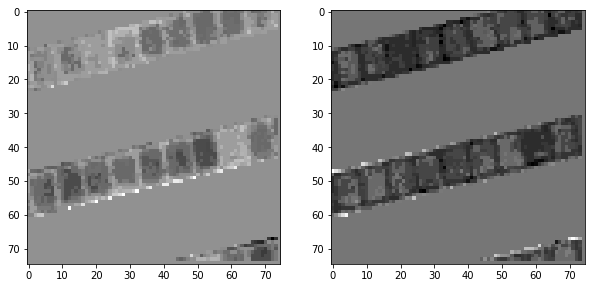

In [74]:
_, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(pca_positive_images[0][:,:,0], cmap="gray")
ax[1].imshow(pca_positive_images[0][:,:,1], cmap="gray")


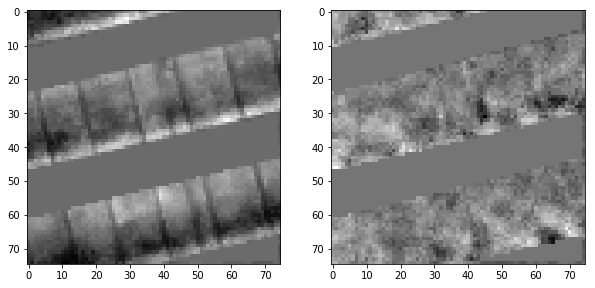

In [75]:
_, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(pca_negative_images[0][:,:,0], cmap="gray")
ax[1].imshow(pca_negative_images[0][:,:,1], cmap="gray")

In [76]:
pca_positive_images.min(), pca_positive_images.max()

(-8301.972595104235, 12705.930753781298)

In [77]:
pca_positive_images.shape

(120, 75, 75, 2)

## Spreak of classes in PCA transformed color space

Plot the color distributions of the solar panels and the backgrounds in the PCA transformed space and see where they differ. First, we plot the color distributions of all the images, after that, we look at individual pictures to compare the solar panel and the background pixels. We also look at the covariance matrices of the individual pictures to see if they differ.

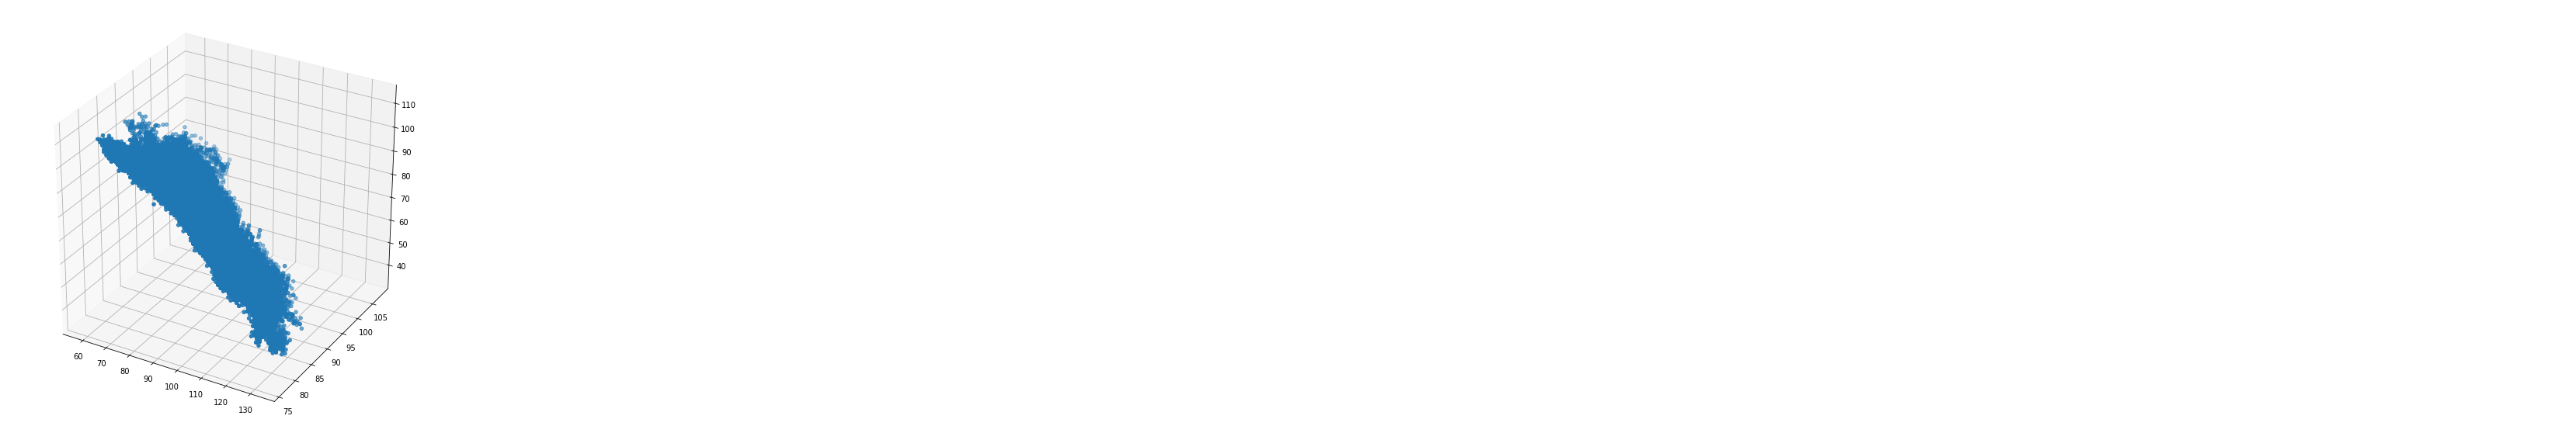

In [78]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rgb_normalized_images.reshape(120 * 75 * 75, 3)[:, 0], rgb_normalized_images.reshape(120 * 75 * 75, 3)[:, 1],rgb_normalized_images.reshape(120 * 75 * 75, 3)[:, 2])

(-5000, 5000)

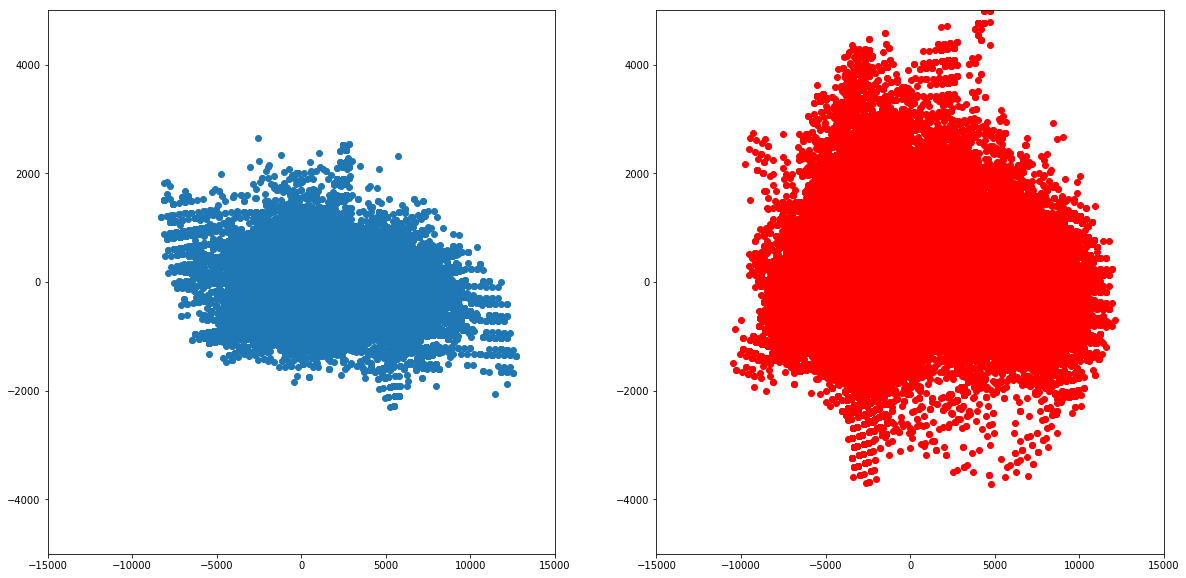

In [79]:
_, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].scatter(pca_positive_images.reshape(120 * 75 * 75, 2)[:,0], pca_positive_images.reshape(120 * 75 * 75,2)[:,1])
ax[1].scatter(pca_negative_images.reshape(120 * 75 * 75, 2)[:,0], pca_negative_images.reshape(120 * 75 * 75,2)[:,1], color='r')
ax[0].set_xlim(-15000,15000)
ax[1].set_xlim(-15000,15000)

ax[0].set_ylim(-5000,5000)
ax[1].set_ylim(-5000,5000)

(-5000, 5000)

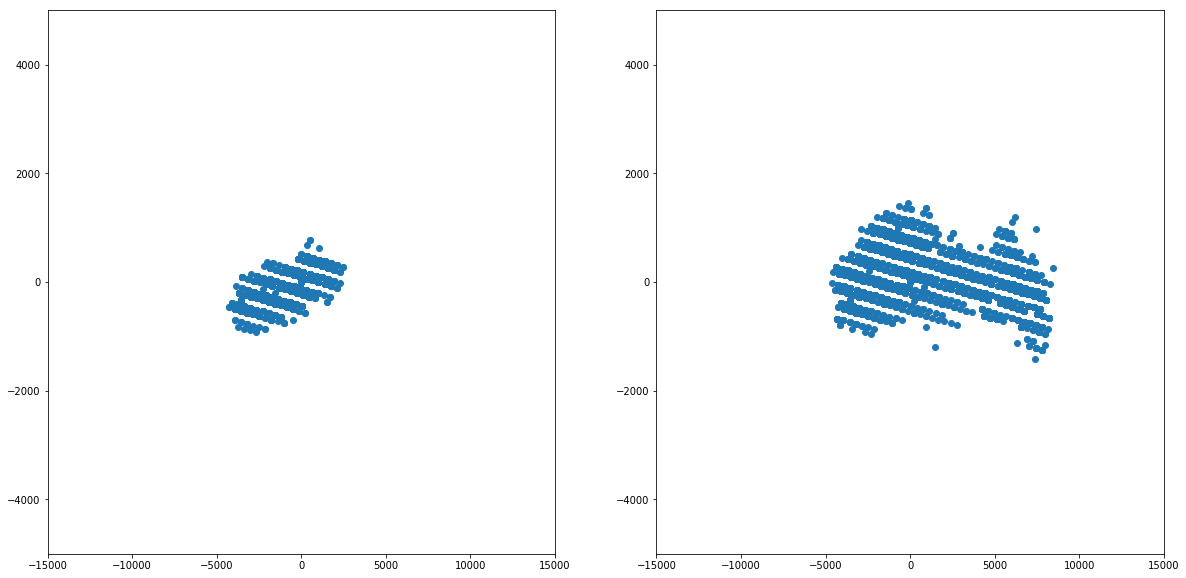

In [80]:
_, ax = plt.subplots(1,2, figsize=(20,10))

i = 4
ax[0].scatter(pca_positive_images[i].reshape(75*75, 2)[:,0], pca_positive_images[i].reshape(75*75, 2)[:, 1])
ax[1].scatter(pca_negative_images[i].reshape(75*75, 2)[:,0], pca_negative_images[i].reshape(75*75, 2)[:, 1])
ax[0].set_xlim(-15000,15000)
ax[1].set_xlim(-15000,15000)

ax[0].set_ylim(-5000,5000)
ax[1].set_ylim(-5000,5000)

In [86]:
i = 4
print(np.cov(pca_positive_images[i].reshape(75*75, 2).T))
print(np.cov(pca_negative_images[i].reshape(75*75, 2).T))

[[808288.29721682  91264.72280136]
 [ 91264.72280136  23109.81841611]]
[[10949817.24271066  -105111.93672279]
 [ -105111.93672279   172449.34883756]]


In [87]:
def pca_bands_hist(hist_image, mask):
    mask_2d = np.stack((mask, mask), axis = 2)
    masked_image = mask_2d * hist_image
    
    hist_c1, _ = np.histogram(masked_image[:,:,0], bins=256)
    hist_c2, _ = np.histogram(masked_image[:,:,1], bins=256)
    return np.concatenate((hist_c1, hist_c2))
    

In [88]:
pca_positives = np.array([pca_bands_hist(hist_image, mask) / mask.size for hist_image, mask in zip(pca_images, mask_images)]).reshape(120, 512)
pca_negatives = np.array([pca_bands_hist(hist_image, mask) / mask.size for hist_image, mask in zip(pca_images, inverse_masks)]).reshape(120, 512)
pca_positives.shape, pca_negatives.shape

((120, 512), (120, 512))

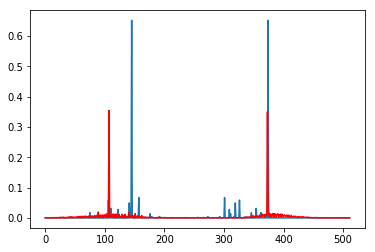

In [89]:
plt.plot(pca_positives[0])
plt.plot(pca_negatives[0], color='r')

In [90]:
pca_orig_positives = np.array([pca_bands_hist(hist_image, mask) / mask.size for hist_image, mask in zip(pca_orig_images, mask_images)]).reshape(120, 512)
pca_orig_negatives = np.array([pca_bands_hist(hist_image, mask) / mask.size for hist_image, mask in zip(pca_orig_images, inverse_masks)]).reshape(120, 512)
pca_orig_positives.shape, pca_orig_negatives.shape

((120, 512), (120, 512))

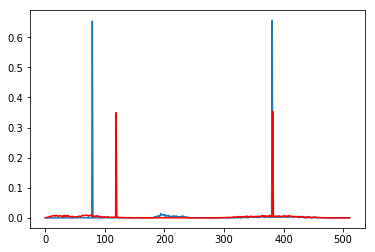

In [91]:
plt.plot(pca_orig_positives[0])
plt.plot(pca_orig_negatives[0], color='r')

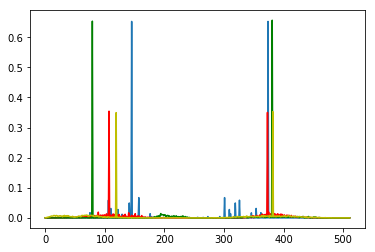

In [92]:
plt.plot(pca_positives[0])
plt.plot(pca_negatives[0], color='r')
plt.plot(pca_orig_positives[0], color='g')
plt.plot(pca_orig_negatives[0], color='y')

In [93]:
pca_positives_summed_hist = pca_positives.sum(axis=0)
pca_negatives_summed_hist = pca_negatives.sum(axis=0)
pca_positives_summed_hist.shape, pca_negatives_summed_hist.shape

((512,), (512,))

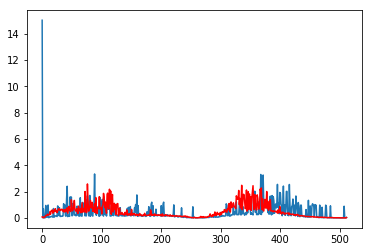

In [94]:
plt.plot(pca_positives_summed_hist)
plt.plot(pca_negatives_summed_hist, color='r')

In [95]:
pca_orig_positives_summed_hist = pca_orig_positives.sum(axis=0)
pca_orig_negatives_summed_hist = pca_orig_negatives.sum(axis=0)
pca_orig_positives_summed_hist.shape, pca_orig_negatives_summed_hist.shape

((512,), (512,))

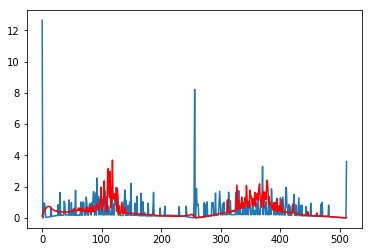

In [96]:
plt.plot(pca_orig_positives_summed_hist)
plt.plot(pca_orig_negatives_summed_hist, color='r')

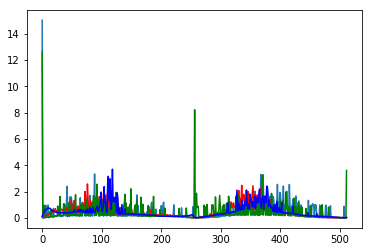

In [97]:
plt.plot(pca_positives_summed_hist)
plt.plot(pca_negatives_summed_hist, color='r')
plt.plot(pca_orig_positives_summed_hist, color='g')
plt.plot(pca_orig_negatives_summed_hist, color='b')

## New classifier

Now use the pca transformed images instead of the rgb images and retrain the classifier.

In [98]:
pca_feature_vectors_positives = np.array([np.concatenate((color, intensity, texture)) for color, intensity, texture in zip(pca_positives, gray_scale_positives, texture_positives)])
pca_feature_vectors_negatives = np.array([np.concatenate((color, intensity, texture)) for color, intensity, texture in zip(pca_negatives, gray_scale_negatives, texture_negatives)])
pca_feature_vectors_positives.shape, pca_feature_vectors_negatives.shape

((120, 794), (120, 794))

In [99]:
pca_all_feature_names = pca_feature_names + gray_scale_feature_names + texture_feature_names

In [100]:
pca_feature_vectors = np.vstack((pca_feature_vectors_positives, pca_feature_vectors_negatives))
pca_feature_vectors.shape

(240, 794)

In [101]:
from sklearn.model_selection import train_test_split

pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(pca_feature_vectors, all_labels, test_size = 0.20)

In [102]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier()
clf.fit(pca_X_train, pca_y_train)

/home/tdjg/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [103]:
predict(clf, pca_X_test, pca_y_test)

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        20
         1.0       1.00      0.93      0.96        28

   micro avg       0.96      0.96      0.96        48
   macro avg       0.95      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48

accuracy=0.9583333333333334
[[20  0]
 [ 2 26]]


In [104]:
clf.feature_importances_

array([0.        , 0.        , 0.        , 0.00740218, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00612812, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00715528, 0.00536741, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01596648, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02485132, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03384306,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00535005, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [105]:
pca_feature_importances = [(name, importance) for name, importance in zip(pca_all_feature_names, clf.feature_importances_) if importance > 0]
pca_feature_importances.sort(key = lambda x: x[1],reverse=True)         
pca_feature_importances

[('gr_245', 0.08028724709318143),
 ('gr_116', 0.07350938213282512),
 ('gr_113', 0.0693843197598747),
 ('t_11', 0.04329665572278173),
 ('gr_122', 0.04154586311698075),
 ('t_19', 0.040349639575053844),
 ('pca_c1_59', 0.03384305835010061),
 ('gr_56', 0.03295185795730715),
 ('gr_93', 0.03294163728946338),
 ('t_24', 0.03190831881533101),
 ('pca_c2_96', 0.028299423348928283),
 ('pca_c1_51', 0.024851324618905397),
 ('t_25', 0.024169337057141135),
 ('t_10', 0.024118269401818236),
 ('t_6', 0.023248364369049125),
 ('gr_125', 0.02251131460530012),
 ('gr_158', 0.017323404168146157),
 ('gr_130', 0.017157359741026945),
 ('pca_c1_30', 0.01596648121044196),
 ('pca_c2_79', 0.014076352137685894),
 ('gr_237', 0.012755147224408112),
 ('gr_53', 0.012648670258617292),
 ('gr_225', 0.012252895509704957),
 ('t_22', 0.010874284959127034),
 ('t_1', 0.008891709109125824),
 ('gr_242', 0.008741176635376187),
 ('pca_c2_151', 0.008445747800586512),
 ('gr_100', 0.008138310679514652),
 ('t_14', 0.008114285714285718),
 

In [106]:
len(pca_feature_importances)

91

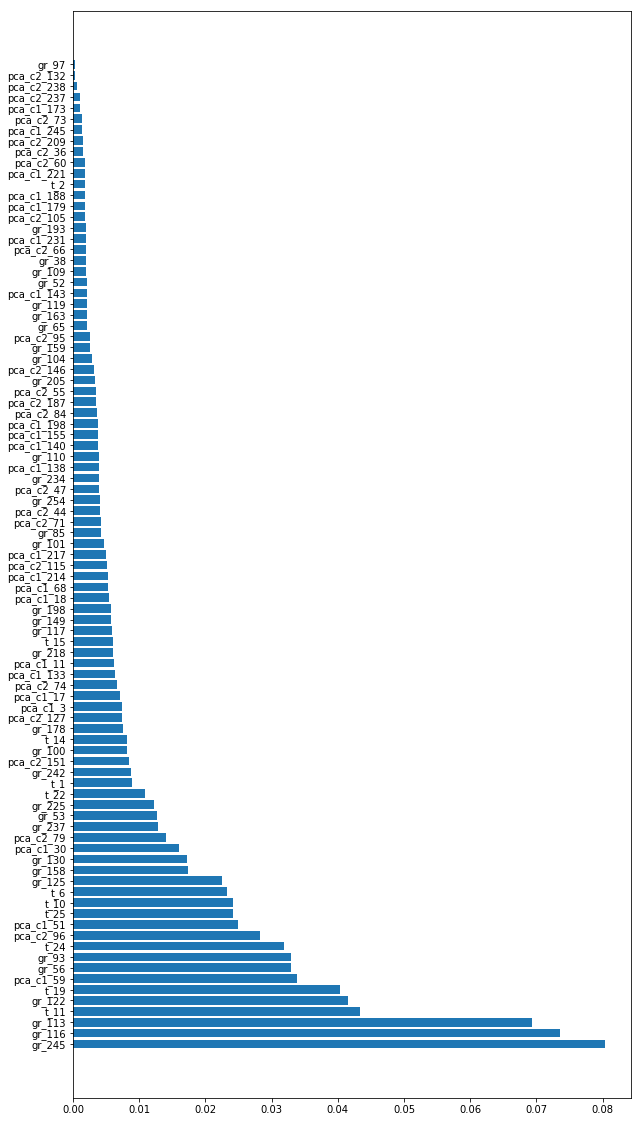

In [107]:
pca_selected_feature_names = [x[0] for x in pca_feature_importances]
pca_selected_importances = [x[1] for x in pca_feature_importances]

ind = np.arange(1, len(pca_feature_importances) + 1)

plt.figure(figsize=(10,20))
h = plt.barh(ind, pca_selected_importances, tick_label=pca_selected_feature_names)

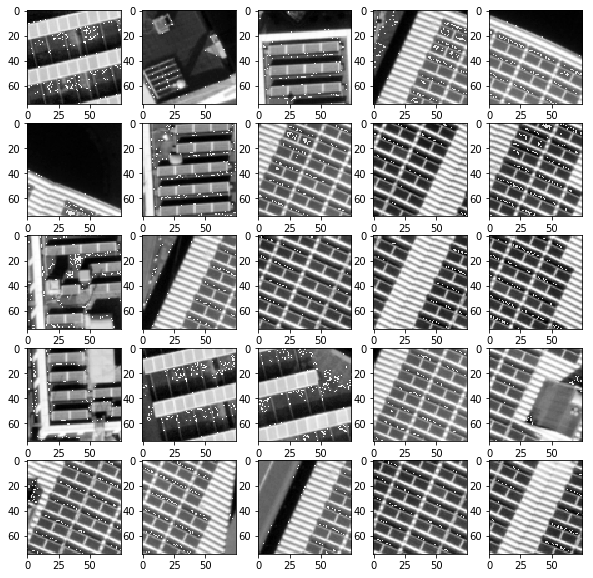

In [108]:
#filtered_picture
_, ax = plt.subplots(5,5, figsize=(10,10))

i = 0
for r in range(5):
    for c in range(5):
        filtered_picture = gray_scale_images[i].copy()
        filtered_picture[np.logical_and(np.logical_and(filtered_picture != 110, filtered_picture != 113), np.logical_and(filtered_picture != 119, filtered_picture != 118))] = 0
        ax[r, c].imshow(gray_scale_images[i].copy() + filtered_picture, cmap='gray')
        i += 1

In [156]:
lbp, hist = desc.lbp_features(gray_scale_images[0])
lbp.shape

(75, 75)

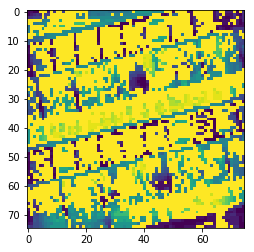

In [157]:
plt.imshow(lbp)

In [123]:
lbp.min(), lbp.max()

(0.0, 25.0)

In [158]:
hist, bins = np.histogram(lbp.ravel(),
            bins=np.arange(0, 24 + 3),
            range=(0, 24 + 2))

In [159]:
hist, bins

(array([ 176,  239,   81,   63,   60,   64,   83,   67,   67,  105,   99,
         148,  348,  164,   83,  101,   36,   58,   24,   19,   11,   29,
          47,   67,   73, 3313]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]))

In [149]:
bins[7]

7

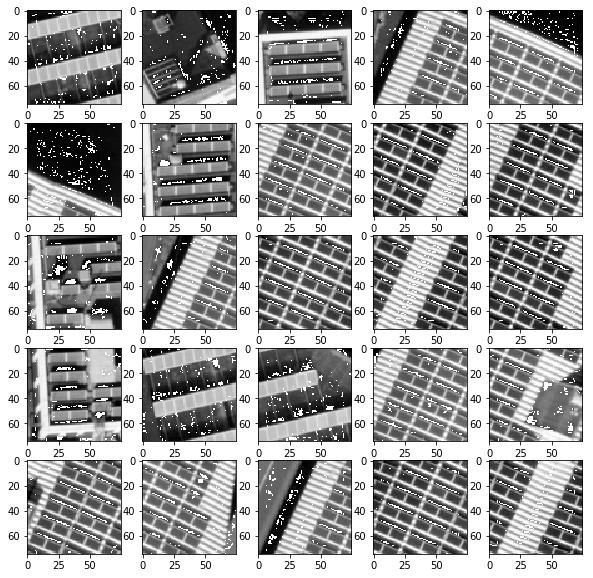

In [163]:
#filtered_picture
_, ax = plt.subplots(5,5, figsize=(10,10))

i = 0
for r in range(5):
    for c in range(5):
        ax[r, c].imshow(desc.draw_into_image(gray_scale_images[i], [11, 19, 24]), cmap='gray')
        i += 1

## Creating a point-based classifier

Using the information above, can we derive a point-based classifier by looking at the probability (based on different histograms/pdfs per feature type) that a picture belongs to a solar panel or the background? 